# EEG Classification of Emotions Using CNN, SAE, and DNN

From the paper "EEG-Based Emotion Classification Using a Deep Neural Network and Sparse Autoencoder", they found to have incredibly high recognition accuracy for emotions using EEG data that they put through a Convolutional Recurrent Neural Network, then a Sparse Autoencoder, and finally a Deep Neural Network.

Paper: https://www.frontiersin.org/articles/10.3389/fnsys.2020.00043/full

DEAP Dataset: https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

SEED Dataset: https://bcmi.sjtu.edu.cn/home/seed/seed.html

Output Labels: [-1: "negative", 0: "neutral", 1: "positive"]

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, freqs, sosfilt
from mlxtend.preprocessing import standardize
from sklearn.model_selection import train_test_split
import scipy.io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

2023-03-26 17:28:16.829396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load SEED Data

- 15 subjects
- 15 sets of 80 second recordings
- 200 Hz recording
- 62 EEG Channels
- (15 * 15) 225 recordings 62 * (200 * 80) 16000 matrixes
- Negative, Neutral, and Positive are recorded for all 15 trials of each subject

Input Matrix Shape: `225 x 62 x 16000`

Output Matrix Shape: `225 x 3`

In [2]:
RECORDINGS_PATH = "/Users/michaelperry/Downloads/SEED_EEG/Preprocessed_EEG_1per/"
ext = ('.mat')

# Gather the filenames and sort them in order of experiment number
files = os.listdir(RECORDINGS_PATH)
files.sort()

# Set the recording rate of the data
HZ = 200

# Get the labels of trials in experiments
mat = scipy.io.loadmat(RECORDINGS_PATH + "label.mat")
# Initialize empty list to put the converted labels into
trial_labels = []
# Iterate through labels and convert to (3,1) classification vector
for l in mat['label'][0]:
    if l == -1:
        trial_labels.append(np.array([1,0,0]))
    elif l == 0:
        trial_labels.append(np.array([0,1,0]))
    elif l == 1:
        trial_labels.append(np.array([0,0,1]))

# Take the list of 1D numpy arrays and
# convert it to 2D matrix
trial_labels = np.stack(trial_labels)

# Initialize empty data and labels arrays
data = []
labels = np.array([[0,0,0]]) # Initialize the shape to stack onto
# Iterate through files in Preprocessed_EEG folder
for file in files:
    # Only look at experiment .mat files
    if file.endswith(ext) and file != "label.mat":
        # Print current file that loading
        print("Loading " + file + "...")
        # Load the .mat file into a dictionary
        mat = scipy.io.loadmat(RECORDINGS_PATH + file)
        # Iterate through all the keys in the dictionary
        for k in mat.keys():
            # Only look at the eeg trials labeled "djc_eeg##"
            if "eeg" in k:
                # Extract data for trial
                trial = mat[k]
                # Take only 80 s after the first 5 s
                # This is to normalize the lengths of trials
                trial = trial[:, 5*HZ:85*HZ]
                # Standardize 2d array
                trial = standardize(trial)
                # Append trial data to data list
                data.append(trial)

        # Append this experiments trial labels to the entire labels vector
        labels = np.vstack([labels, trial_labels])

# Take the list of 2D numpy arrays and
# convert it to 3D matrix
raw = np.stack(data)
# Delete first template row for labels
labels = np.delete(labels, 0, 0)

print("raw Shape:", raw.shape)
print("labels Shape:", labels.shape)

Loading 01_20131027.mat...
Loading 02_20140404.mat...
Loading 03_20140603.mat...
Loading 04_20140621.mat...
Loading 05_20140411.mat...
Loading 06_20130712.mat...
Loading 07_20131027.mat...
Loading 08_20140511.mat...
Loading 09_20140620.mat...
Loading 10_20131130.mat...
Loading 11_20140618.mat...
Loading 12_20131127.mat...
Loading 13_20140527.mat...
Loading 14_20140601.mat...
Loading 15_20130709.mat...
raw Shape: (225, 62, 16000)
labels Shape: (225, 3)


## Band-Pass Filter Functions

In [3]:
# Functions from: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butterhttps://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
# Params from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

## General Band-Pass Filter

- This is used to get rid of general noise
- Done across the Hz range 0.1-45

Input Matrix Shape: `225 x 62 x 16000`

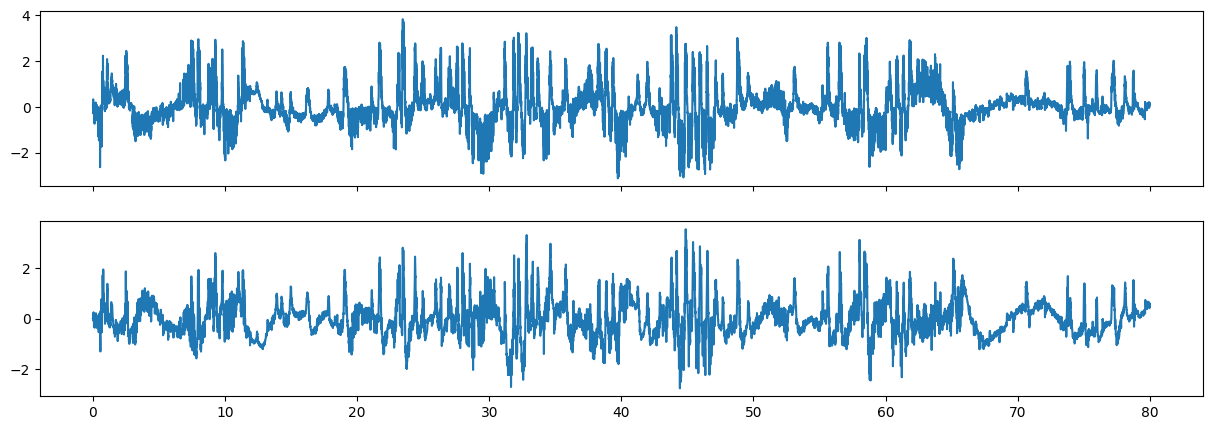

filterData Shape: (225, 62, 16000)


In [4]:
# Filter Params
LOWCUT = 0.1
HIGHCUT = 45.0
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty matrix to put all filtered data into
filterData = np.zeros_like(raw)

# Iterate through each epoch/recording
for idx in range(raw.shape[0]):
    # Get the epoch of the index
    epoch = raw[idx]
    # Initialize empty matrix to put filtered epoch data into
    filteredEpoch = np.zeros_like(epoch)

    # Iterate through the rows of the epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter from 0.1-45 Hz
        filtered = butter_bandpass_filter(channel, LOWCUT, HIGHCUT, HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, 80, HZ*80, False) # timesteps for 80@200Hz
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))
            ax1.plot(t, channel)
            ax2.plot(t, filtered)
            plt.show()
            plotData = False
        
        # Add filtered channel into the filterEpoch matrix
        filteredEpoch[i] = filtered
    
    # Add filtered epoch into the filterData matrix
    filterData[idx] = filteredEpoch

print("filterData Shape:", filterData.shape)

## Butterworth Band-Pass Filter

- $\alpha$ (1-7 Hz), $\beta$ (8-13 Hz), $\theta$ (14-30 Hz), $\lambda$ (30-45 Hz)
- This will break up the single stream of data from each channel into 4 streams of separate bands

Input Matrix Shape: `225 x 4 x 62 x 16000`

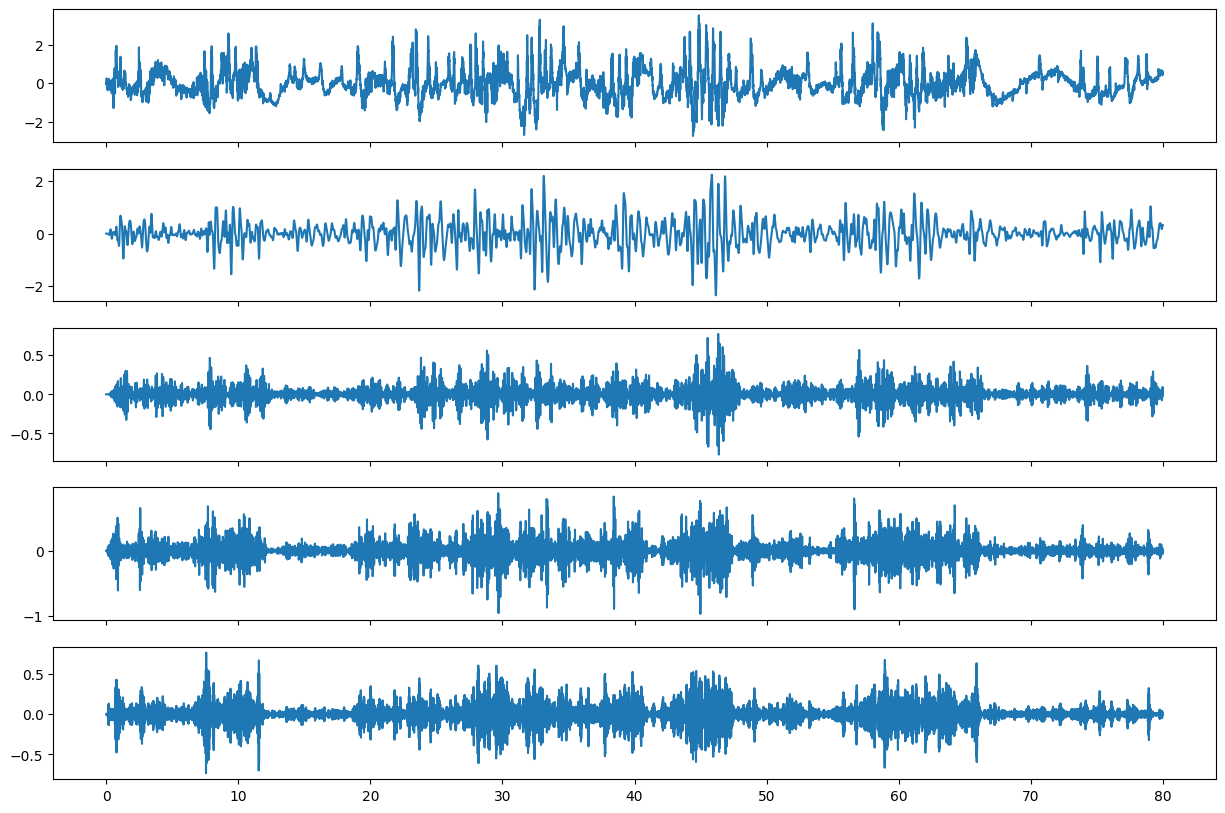

bandData Shape: (225, 4, 62, 16000)


In [5]:
# Filter Params
ALPHA = (1, 7)
BETA = (8, 13)
THETA = (14, 30)
LAMBDA = (30, 45)
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty list to put all epoched band data into
bandData = []

# Iterate through each filtered epoch/recording
for idx in range(filterData.shape[0]):
    # Get the epoch of the index
    epoch = filterData[idx]
    # Initialize empty matrixs to put band data into
    alphaData = np.zeros_like(epoch)
    betaData = np.zeros_like(epoch)
    thetaData = np.zeros_like(epoch)
    lambdaData = np.zeros_like(epoch)

    # Iterate through the rows of the filtered epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter for each band on a channel
        alphaChan = butter_bandpass_filter(channel, ALPHA[0], ALPHA[1], HZ, order=ORDER)
        betaChan = butter_bandpass_filter(channel, BETA[0], BETA[1], HZ, order=ORDER)
        thetaChan = butter_bandpass_filter(channel, THETA[0], THETA[1], HZ, order=ORDER)
        lambdaChan = butter_bandpass_filter(channel, LAMBDA[0], LAMBDA[1], HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, 80, HZ*80, False) # timesteps for 80@200Hz
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(15,10))
            ax1.plot(t, channel)
            ax2.plot(t, alphaChan)
            ax3.plot(t, betaChan)
            ax4.plot(t, thetaChan)
            ax5.plot(t, lambdaChan)
            plt.show()
            plotData = False

        # Add each band channel vector into its respective matrix
        alphaData[i] = alphaChan
        betaData[i] = betaChan
        thetaData[i] = thetaChan
        lambdaData[i] = lambdaChan
    
    # Initialize list of band data
    epochBandData = [alphaData, betaData, thetaData, lambdaData]
    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    epochBandData = np.stack(epochBandData)
    # Append the epochBandData to bandData list
    bandData.append(epochBandData)

# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
bandData = np.stack(bandData)

print("bandData Shape:", bandData.shape)

## Epoch the Epochs

- For each trils of 80 s, 19 segments are obtained using an 8 s time window moving every 4 s.
- This will extrapolate our training data
- (200 * 80) => (200 * 8)
- 16000 => 1600
- 225 * 19 = 4275
- Increasing our input data means we increase output
- All 19 new samples from each apoch have the same output

Input Matrix Shape: `4275 x 4 x 62 x 1600`

Output Matrix Shape: `4275 x 3`

In [6]:
# Initialize empty lists to put all 8 seconds epochs and new labels into respectively
epochData = []
epochLabels = []

# Iterate through each filtered band epoch/recording
for idx in range(bandData.shape[0]):
    # Get the epoch of the index
    epoch = bandData[idx]
    label = labels[idx]

    # Iterrate through 8 second time intervals 
    for t in range(0, epoch.shape[2], HZ*4):
        # Break if 8 seconds goes past end of recording
        if (t + HZ*8 > epoch.shape[2]):
            break

        # Initialize empty matrix to put 8 s epoch into (4, 14, 1024)
        epoch8 = np.zeros((epoch.shape[0], epoch.shape[1], HZ*8))

        # Iterate through each band in the epoch
        for i in range(epoch.shape[0]):
            # Add the time interval from this
            # band into the epoch8 matrix
            epoch8[i] = epoch[i,:,t:t+HZ*8]

        # Append 8 second epoch to epochData list
        epochData.append(epoch8)
        # Append current label to epochLabels list
        epochLabels.append(label)

# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
epochData = np.stack(epochData)
# Convert list to numpy array
epochLabels = np.array(epochLabels)

print("epochData Shape:", epochData.shape)
print("epochLabels Shape:", epochLabels.shape)

epochData Shape: (4275, 4, 62, 1600)
epochLabels Shape: (4275, 3)


## PCC Feature Extraction

- PCC (Pearson Correlation Coefficient)
- On every band and epoch
- Basically calculating correlation of every channel pair against each other
- (62 x 1600) => (62 x 62)

Input Matrix Shape: `4275 x 4 x 62 x 62`

In [7]:
# Initialize empty list to put the PCC data into
pccData = []

print("epochData Shape:", epochData.shape)
# Iterate through each epoch
for idx in range(epochData.shape[0]):
    # Get the epoch of the index
    epoch = epochData[idx]
    # Initialize empty list to put the epoch PCC data into
    pccEpoch = []
    
    # Iterate through each band
    for i in range(epoch.shape[0]):
        # Get the band of the index
        band = epoch[i]
        # Extract PCC from the band
        pcc = np.corrcoef(band)
        # Append PCC features into pccEpoch list
        pccEpoch.append(pcc)

    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    pccEpoch = np.stack(pccEpoch)
    # Append the pccEpoch to pccData list
    pccData.append(pccEpoch)
    
# Take the list of 3D numpy arrays and
# convert it to 4D matrix
pccData = np.stack(pccData)

print("pccData Shape:", pccData.shape)


epochData Shape: (4275, 4, 62, 1600)
pccData Shape: (4275, 4, 62, 62)


# Resphape to Multi-Image Format

- 4 x 62 x 62 ==> 62 x 62 x 2
- This is the format that works for images with rgb values
    - A 2D matrix with 3 rgb values (n x m x 3)
    - We have a 2D matrix with 4 bands of data

Input Matrix Shape: `4275 x 62 x 62 x 4`

In [8]:
# Initialize empty list to put reshaped data into
reshapedData = [np.transpose(i, (1, 2, 0)) for i in pccData]
reshapedData = np.stack(reshapedData)

print("reshapedData Shape:", reshapedData.shape)

reshapedData Shape: (4275, 62, 62, 4)


## Split Training and Testing Set

- 80% Training, 20% Testing

Training Input Matrix Shape: `3420 x 62 x 62 x 4`

Training Output Matrix Shape: `3420 x 3`

Testing Input Matrix Shape: `855 x 62 x 62 x 4`

Testing Output Matrix Shape: `855 x 3`

In [9]:
print("Input Shape:", reshapedData.shape)
print("Output Shape:", epochLabels.shape)

x_train, x_test, y_train, y_test = train_test_split(reshapedData, epochLabels, random_state=0, train_size = 0.8)

print()
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)

Input Shape: (4275, 62, 62, 4)
Output Shape: (4275, 3)

x_train Shape: (3420, 62, 62, 4)
y_train Shape: (3420, 3)
x_test Shape: (855, 62, 62, 4)
y_test Shape: (855, 3)


## Develop Convolutional Neural Network (CNN)

- Input Convolutional Layer
    - Input Size: Four 62 x 62 "images" (4 bands PCC matrix)
    - Kernel Size = 3 x 1
    - \# of Kernels = 8
- Hidden Convolutional Layer
    - Kernel Size = 3 x 1
    - \# of Kernels = 16
- Dropout Layer
- Hidden Max-Pooling Layer
    - Pooling Size = 3 x 3
- Dropout Layer
- Staging Layer
    - Shape: 16 * 20 * 19
- Output Layer
    - (Valence, Arousal) tuple

In [10]:
CNN_1 = models.Sequential()
CNN_1.add(layers.Conv2D(8, (3, 1), activation='relu', input_shape=(62,62,4)))
CNN_1.add(layers.Dropout(0.2))
CNN_1.add(layers.Conv2D(16, (3, 1), activation='relu'))
CNN_1.add(layers.Dropout(0.2))
CNN_1.add(layers.MaxPooling2D(pool_size=(3,3)))
CNN_1.add(layers.Flatten())
CNN_1.add(layers.Dense(512, activation='relu', name="CNN_Output"))
CNN_1.add(layers.Dense(3, activation='softmax'))

CNN_1.summary()

2023-03-26 17:37:50.936097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 62, 8)         104       
                                                                 
 dropout (Dropout)           (None, 60, 62, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 62, 16)        400       
                                                                 
 dropout_1 (Dropout)         (None, 58, 62, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 20, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6080)              0         
                                                        

## Train CNN

- Training Epochs = 50
- Batch Size = 128
- Learning Rate = 0.01
- Optimizer = "adam"

In [11]:
# Will be implemented once we know what the output data is.
CNN_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = CNN_1.fit(x_train, y_train, epochs=50, batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/50
27/27 [==============================] - 9s 250ms/step - loss: 2.0079 - accuracy: 0.3412 - val_loss: 1.0902 - val_accuracy: 0.4117
Epoch 2/50
27/27 [==============================] - 6s 212ms/step - loss: 1.0926 - accuracy: 0.3807 - val_loss: 1.0785 - val_accuracy: 0.4199
Epoch 3/50
27/27 [==============================] - 6s 219ms/step - loss: 1.0599 - accuracy: 0.4471 - val_loss: 1.0536 - val_accuracy: 0.5462
Epoch 4/50
27/27 [==============================] - 6s 227ms/step - loss: 1.0269 - accuracy: 0.4974 - val_loss: 1.0251 - val_accuracy: 0.5485
Epoch 5/50
27/27 [==============================] - 5s 202ms/step - loss: 0.9833 - accuracy: 0.5412 - val_loss: 1.0021 - val_accuracy: 0.4784
Epoch 6/50
27/27 [==============================] - 7s 247ms/step - loss: 0.9429 - accuracy: 0.5500 - val_loss: 0.9471 - val_accuracy: 0.5614
Epoch 7/50
27/27 [==============================] - 6s 204ms/step - loss: 0.8988 - accuracy: 0.5792 - val_loss: 0.9053 - val_accuracy: 0.6199
Epoch 

27/27 - 0s - loss: 0.4676 - accuracy: 0.8094 - 314ms/epoch - 12ms/step
test_acc: 0.8093567490577698


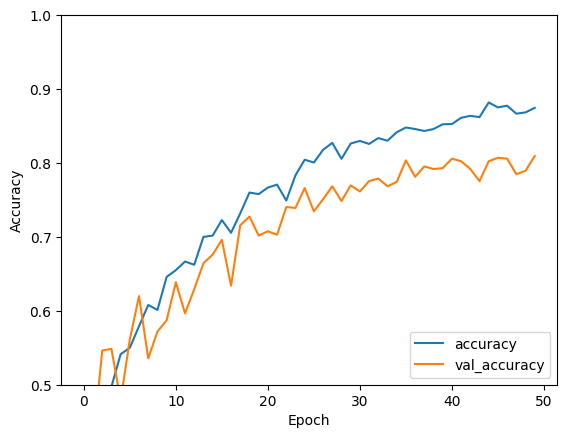

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = CNN_1.evaluate(x_test, y_test, verbose=2)

print("test_acc:", test_acc)

## After Training, Drop Output Layer

- This makes the Staging Layer the new Output Layer
- Run Training Input Matrix through CNN an get the output.
- **Note:** Just using a CNN for classification is known to not have the best results. This is the main idea of the paper. We initially have a 2-neuron output layer for training in order for back propagation in the CNN to adjust the weights, but then dorp the output layer and take the data in the staging layer, flatten it, and put it into the SAE

Training Input Matrix Size: `14336 x 64 x 10 x 9`

In [13]:

# Initialize Test Input
test_in = np.expand_dims(x_train[0], axis=0)
print(test_in.shape)

# Test Output Before
out = CNN_1.predict(test_in)
print("Original Output Shape:", out.shape)
print("Original Output:", out)

# Drop Fully Connected Output Layer
CNN_1.summary()
CNN_2 = models.Model(inputs=CNN_1.input, outputs=CNN_1.get_layer("CNN_Output").output)
CNN_2.summary()

# Test Output After
out = CNN_2.predict(test_in)
print("Dropped Output Shape:", out.shape)

(1, 62, 62, 4)
1/1 [==============================] - 0s 208ms/step
Original Output Shape: (1, 3)
Original Output: [[0.13602862 0.82494617 0.03902526]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 62, 8)         104       
                                                                 
 dropout (Dropout)           (None, 60, 62, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 62, 16)        400       
                                                                 
 dropout_1 (Dropout)         (None, 58, 62, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 20, 16)       0         
 )                                                               
                                    

## Get Training Data for SAE

- Data needs to be one-dimensional to go into SAE

Training Input Matrix Size: `14336 x 5760`

In [14]:
# Print Shape of Input going into CNN model
print("Train Input to CNN Shape:", x_train.shape)
print("Test Input to CNN Shape:", x_test.shape)

# Get the output of the trained CNN for training and testing input in the SAE
train_SAE = CNN_2.predict(x_train)
test_SAE = CNN_2.predict(x_test)

# Print Shape of Output from CNN
print("SAE Training Input Shape:", train_SAE.shape)
print("SAE Testing Input Shape:", test_SAE.shape)

Train Input to CNN Shape: (3420, 62, 62, 4)
Test Input to CNN Shape: (855, 62, 62, 4)
27/27 [==============================] - 0s 11ms/step
SAE Training Input Shape: (3420, 512)
SAE Testing Input Shape: (855, 512)


## Develop Sparse Autoencoder (SAE)

- Input Layer: 6080 Nodes
- Encoder Layer: 512 Nodes
- Hidden Layer: 128 Nodes
- Output Decoder Layer: 512 Nodes

In [15]:
# Shapes
SAE_n_inputs = train_SAE.shape[1]
SAE_n_hidden = 128

# Layers
SAE_visible = layers.Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer')
SAE_enc_hidden = layers.Dense(units=SAE_n_inputs, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible)
SAE_bottleneck = layers.Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.0001), name='SAE-Bottleneck-Layer')(SAE_enc_hidden)
SAE_dec_output = layers.Dense(units=SAE_n_inputs, activation='relu', name='SAE-Decoder-Output-Layer')(SAE_bottleneck)

# Define Sparse Autoencoder Model
SAE_model = models.Model(inputs=SAE_visible, outputs=SAE_dec_output, name='Sparse-Autoencoder-Model')

# Print Model Summary
print(SAE_model.summary())

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 512)              262656    
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 128)              65664     
 )                                                               
                                                                 
 SAE-Decoder-Output-Layer (D  (None, 512)              66048     
 ense)                                                           
                                                                 
Total params: 394,368
Trainable params: 39

## Train SAE

- SAE's are unsupervised learning models so we don't train it against an expected output.
- Training Epochs = 100
- Batch Size = 64
- Learning Rate = 0.01

In [16]:
# Compile Sparse Autoencoder Model
SAE_model.compile(optimizer='adam', loss='mse')

# Fit the Sparse Autoencoder Model to Reconstruct Input
SAE_history = SAE_model.fit(train_SAE, train_SAE, epochs=100, batch_size=64, verbose=1, validation_data=(test_SAE, test_SAE))

Epoch 1/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0943 - val_loss: 0.0501
Epoch 2/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0480 - val_loss: 0.0447
Epoch 3/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0424 - val_loss: 0.0316
Epoch 4/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0215
Epoch 5/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0198
Epoch 6/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0197 - val_loss: 0.0189
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0156
Epoch 8/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0150
Epoch 9/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 10/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0086
Epoch 1

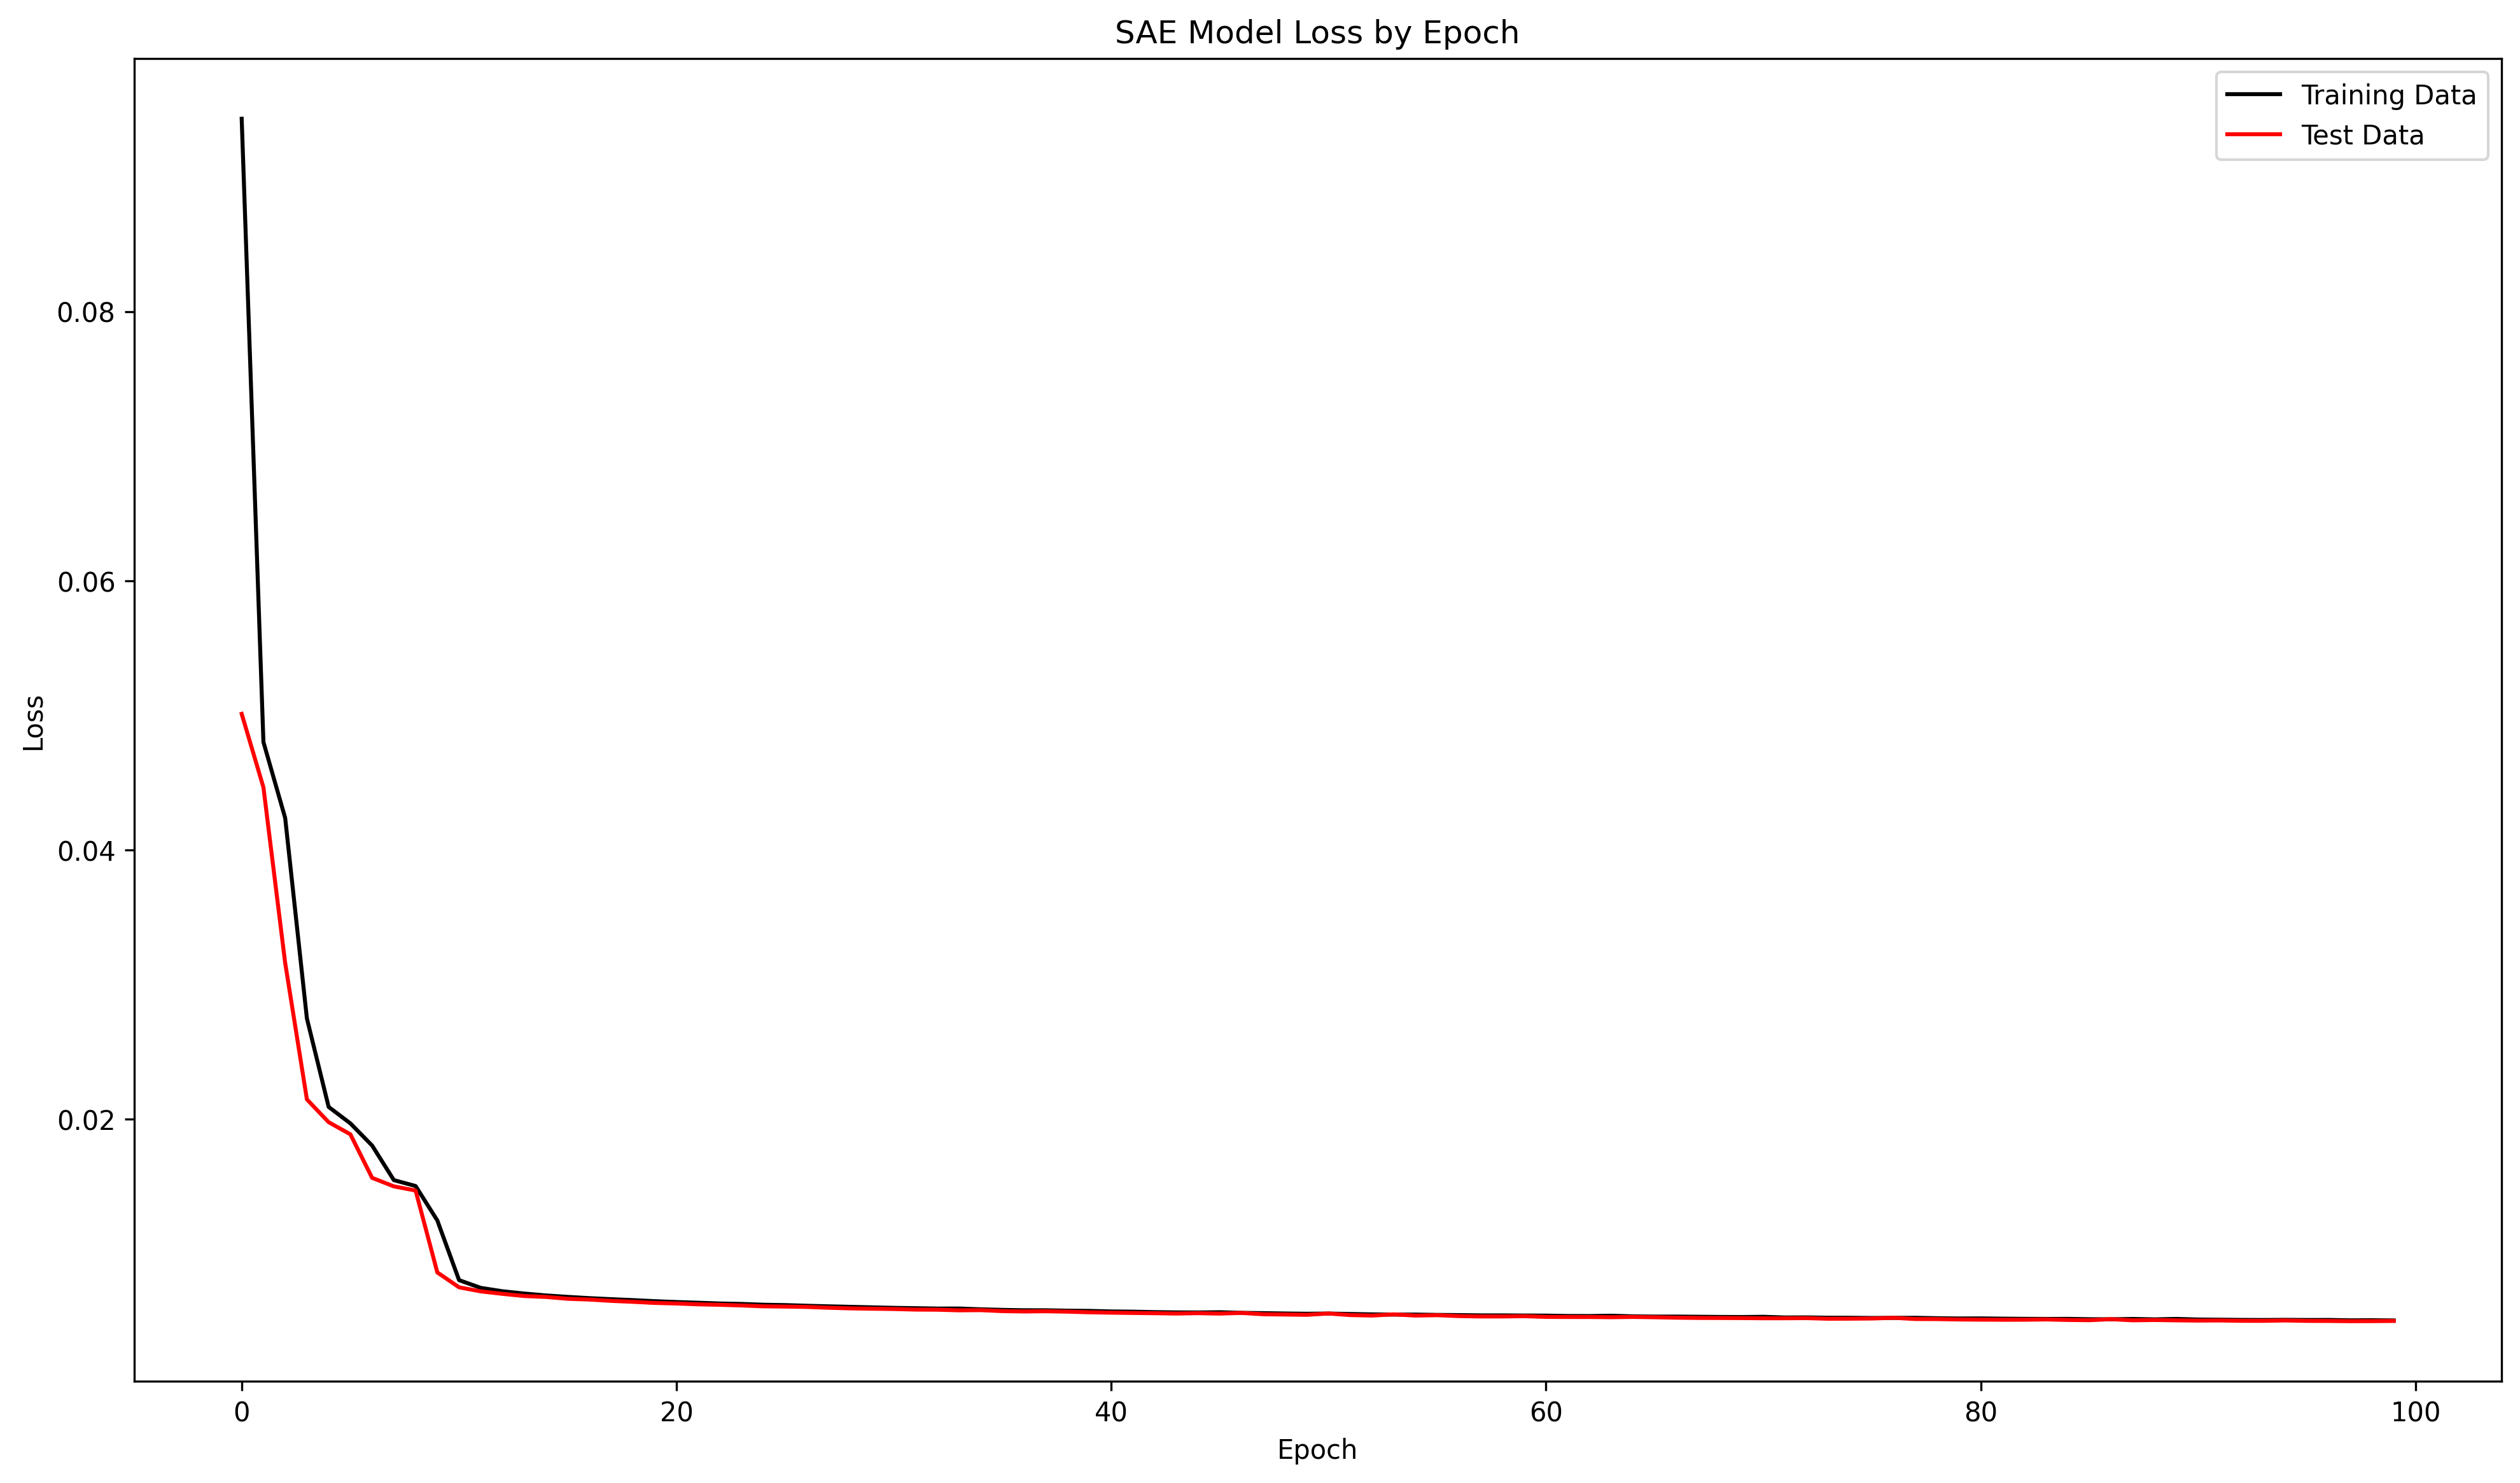

In [17]:
#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['loss'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()

## Get SAE Output

- Using the flattened output from the CNN as input to the trained SAE, get the output to use as training data for DNN

Training Input Matrix Shape: `14336 x 512`

In [18]:
cnn_out = CNN_2.predict(reshapedData)
sae_out = SAE_model.predict(cnn_out)
print("DNN Training Input Shape:", sae_out.shape)

134/134 [==============================] - 0s 1ms/step
DNN Training Input Shape: (4275, 512)


# Split Train and Test Set from SAE Output

In [20]:
print("Input Shape:", sae_out.shape)
print("Output Shape:", epochLabels.shape)

x_train, x_test, y_train, y_test = train_test_split(sae_out, epochLabels, random_state=0, train_size = 0.8)

print()
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)

Input Shape: (4275, 512)
Output Shape: (4275, 3)

x_train Shape: (3420, 512)
y_train Shape: (3420, 3)
x_test Shape: (855, 512)
y_test Shape: (855, 3)


## Develop Deep Neural Network (DNN)

- Fully Connected Input Layer: 512 Nodes
- Fully Connected Hidden Layer: 256 Nodes
- Fully Connected Output Layer: 3 Nodes ((Negative, Neutral, Positive) tuple)

In [26]:
# Shapes
DNN_n_inputs  = x_train.shape[1]
DNN_n_hidden  = 256
DNN_n_outputs = 3
print(DNN_n_inputs)
# Layers
DNN_input = layers.Input(shape=(DNN_n_inputs,), name='DNN-Input-Layer')
DNN_hidden = layers.Dense(DNN_n_hidden, activation='relu', name='DNN-Hidden-Layer')(DNN_input)
DNN_output = layers.Dense(DNN_n_outputs, activation='sigmoid', name='DNN-Output-Layer')(DNN_hidden)

# Define DNN Model
DNN_model = models.Model(inputs=DNN_input, outputs=DNN_output, name='DNN-Model')

# Print Model Summary
print(DNN_model.summary())

512
Model: "DNN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DNN-Input-Layer (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 DNN-Hidden-Layer (Dense)    (None, 256)               131328    
                                                                 
 DNN-Output-Layer (Dense)    (None, 3)                 771       
                                                                 
Total params: 132,099
Trainable params: 132,099
Non-trainable params: 0
_________________________________________________________________
None


## Train DNN

- Use the output of the trained SAE as training input for the DNN. The expected outputs to the DNN are teh original (V,A) tuple.
- Training Epochs = 100
- Batch Size = 128
- Learning Rate = 0.01

In [27]:
# Compile DNN Model
DNN_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Fit the DNN Model
DNN_history = DNN_model.fit(x_train, y_train, epochs=100, batch_size=128,
                            validation_data=(x_test, y_test))

Epoch 1/100
27/27 [==============================] - 1s 11ms/step - loss: 0.5833 - accuracy: 0.8368 - val_loss: 0.4649 - val_accuracy: 0.8175
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 0.2342 - accuracy: 0.9284 - val_loss: 0.4505 - val_accuracy: 0.8152
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1895 - accuracy: 0.9365 - val_loss: 0.4564 - val_accuracy: 0.8222
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1724 - accuracy: 0.9389 - val_loss: 0.4709 - val_accuracy: 0.8246
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1670 - accuracy: 0.9389 - val_loss: 0.4691 - val_accuracy: 0.8246
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1565 - accuracy: 0.9427 - val_loss: 0.4797 - val_accuracy: 0.8175
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.9442 - val_loss: 0.4764 - val_accuracy: 0.8269
Epoch 8/100


27/27 - 0s - loss: 0.5194 - accuracy: 0.8433 - 65ms/epoch - 2ms/step
test_acc: 0.8432748317718506


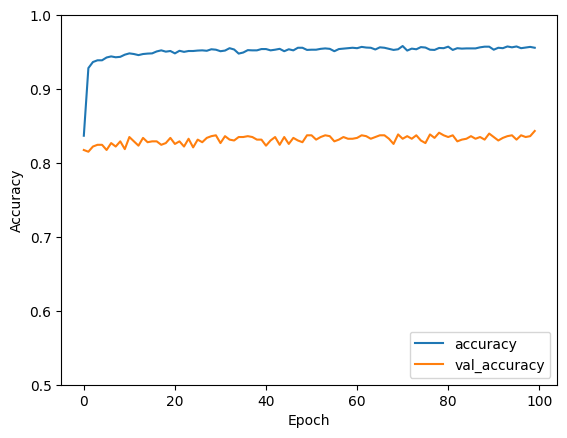

In [29]:
plt.plot(DNN_history.history['accuracy'], label='accuracy')
plt.plot(DNN_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = DNN_model.evaluate(x_test, y_test, verbose=2)

print("test_acc:", test_acc)

# Save All Three Models

In [30]:
# CNN Model
CNN_2.save('CNNModel.1.0.h5')
# CNN Weights
CNN_2.save_weights('CNNWeights.1.0')

# SAE Model
SAE_model.save('SAEModel.1.0.h5')
# SAE Weights
SAE_model.save_weights('SAEWeights.1.0')

# DNN Model
DNN_model.save('DNNModel.1.0.h5')
# DNN Weights
DNN_model.save_weights('DNNWeights.1.0')